Bien sûr ! La régularisation L1, également appelée "Lasso" (Least Absolute Shrinkage and Selection Operator), est une méthode de régularisation qui vise à contrôler la complexité d'un modèle en ajoutant une pénalité proportionnelle à la valeur absolue des poids du modèle.

Mathématiquement, la régularisation L1 peut être représentée comme suit :

Pendant l'entraînement d'un modèle, la fonction de perte à optimiser est modifiée pour inclure le terme de régularisation L1. Pour un modèle avec des poids $ w $, la fonction de perte régularisée devient :

$$ \text{Perte régularisée} = \text{Perte d'origine} + \lambda \sum_i |w_i| $$

Ici, $ \lambda $ est le paramètre de régularisation qui contrôle l'importance de la régularisation L1. Plus $ \lambda $ est grand, plus la pénalité sur les valeurs absolues des poids est forte.

L'objectif principal de la régularisation L1 est de favoriser la parcimonie des poids du modèle en encourageant certains poids à devenir exactement égaux à zéro. Cela peut conduire à une sélection de fonctionnalités, car les poids correspondant à des fonctionnalités moins importantes peuvent être réduits à zéro, rendant ainsi le modèle plus simple et plus interprétable.

Pendant l'évaluation ou l'inférence, la régularisation L1 n'est pas appliquée ; le modèle est utilisé tel quel, sans modification des poids.

En résumé :
- Pendant l'entraînement : On ajoute un terme de pénalité $ \lambda \sum_i |w_i| $ à la fonction de perte d'origine pour contrôler la complexité du modèle.
- Pendant l'évaluation : On utilise le modèle entraîné tel quel, sans modification des poids avec la régularisation L1.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:00<00:00, 117554320.69it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6672499.46it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 76602940.22it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21168899.01it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 10)



    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
# Affichage des poids à la fin de l'entraînement pour chaque cas
def plot_weights(weights, title, ax):
                im = ax.imshow(weights, cmap='jet')
                ax.set_title(title)
                ax.axis('off')
                plt.colorbar(im, ax=ax)

def display_weights(model_state_dict, description):
                model = MLP().to(device)
                model.load_state_dict(model_state_dict)
                model.eval()

                fig, axs = plt.subplots(2, 2, figsize=(12, 8))

                plot_weights(model.fc1.weight.cpu().detach().numpy(), f'Couche 1 ({description})', axs[0, 0])
                plot_weights(model.fc2.weight.cpu().detach().numpy(), f'Couche 2 ({description})', axs[0, 1])
                plot_weights(model.fc3.weight.cpu().detach().numpy(), f'Couche 3 ({description})', axs[1, 0])
                plot_weights(model.fc4.weight.cpu().detach().numpy(), f'Couche 4 ({description})', axs[1, 1])

                plt.tight_layout()
                plt.show()


In [ ]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


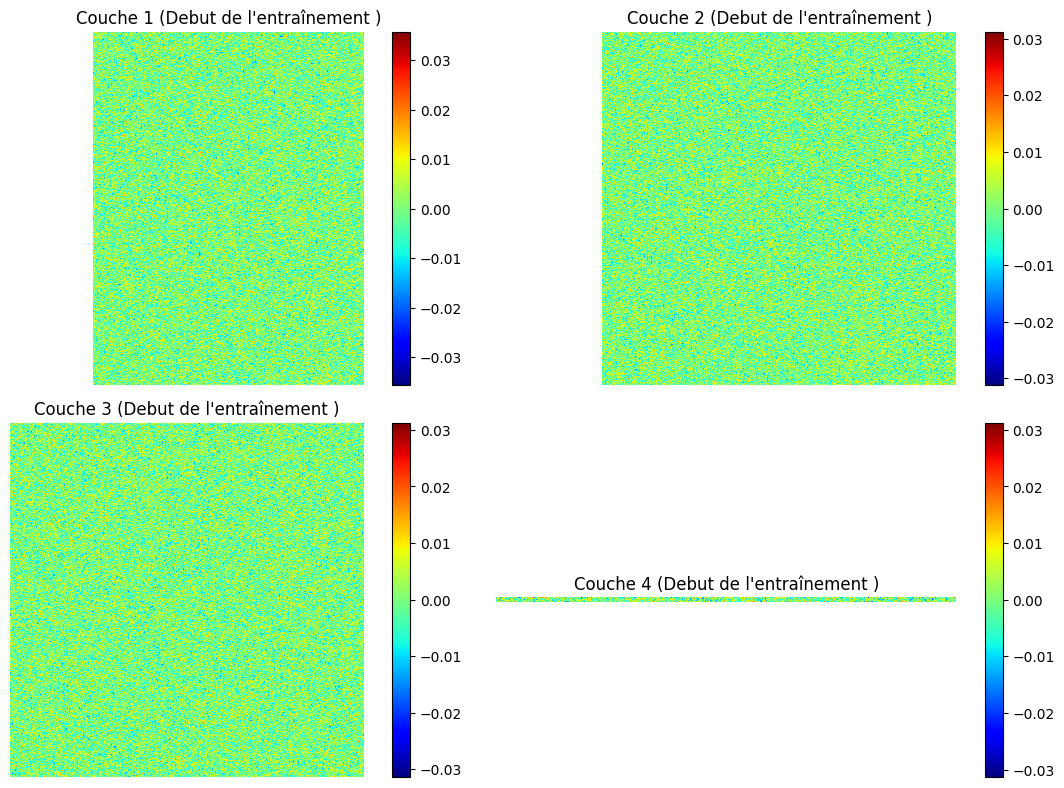

In [ ]:
display_weights(model.state_dict(), "Debut de l'entraînement ")

In [ ]:
best_accuracy = 0
best_model_state = None
print(f"Entraînement du modèle")

for epoch in range(10):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)


            l1_loss = 0
            for param in model.parameters():
                    l1_loss += torch.norm(param, 1)
            loss += 0.0001 * l1_loss

            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/10], Précision sur l'ensemble de validation : {accuracy:.2f}%")

        if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = model.state_dict()





Entraînement du modèle
Epoch [1/10], Précision sur l'ensemble de validation : 83.21%
Epoch [2/10], Précision sur l'ensemble de validation : 84.78%
Epoch [3/10], Précision sur l'ensemble de validation : 83.45%
Epoch [4/10], Précision sur l'ensemble de validation : 85.55%
Epoch [5/10], Précision sur l'ensemble de validation : 84.65%
Epoch [6/10], Précision sur l'ensemble de validation : 86.46%
Epoch [7/10], Précision sur l'ensemble de validation : 84.62%
Epoch [8/10], Précision sur l'ensemble de validation : 86.06%
Epoch [9/10], Précision sur l'ensemble de validation : 86.75%
Epoch [10/10], Précision sur l'ensemble de validation : 86.66%


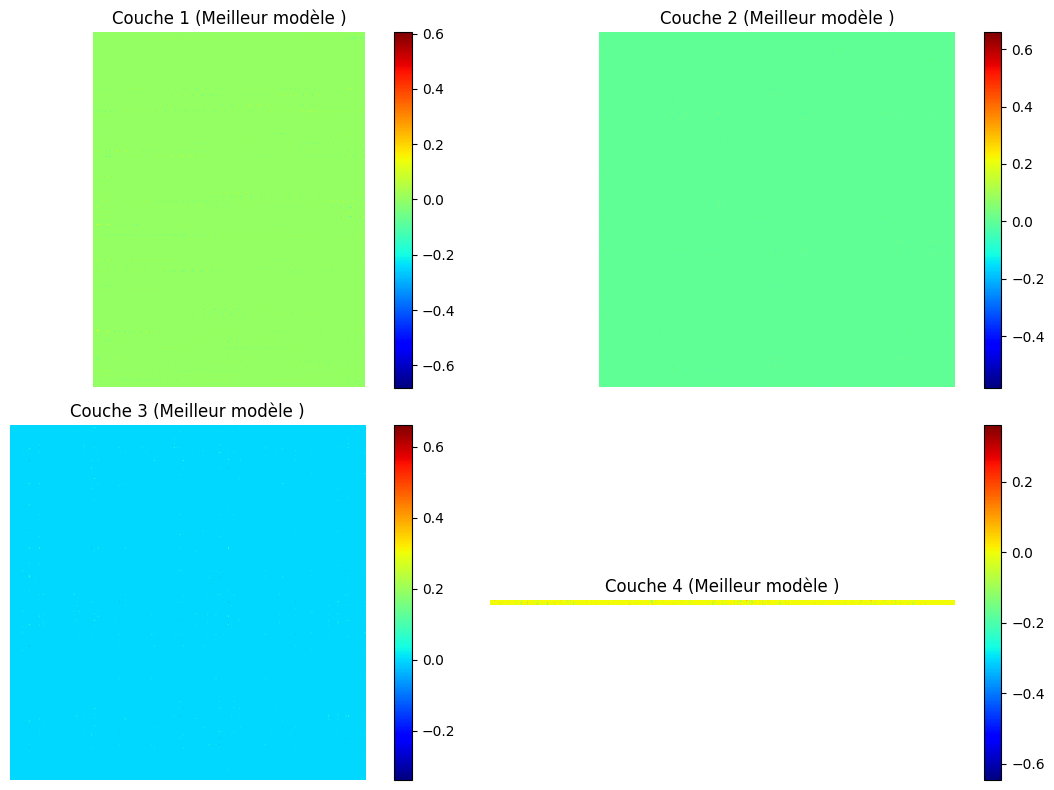

In [ ]:
display_weights(best_model_state, "Meilleur modèle ")


In [35]:
sparsity_values = []

for name, param in model.named_parameters():
                if 'weight' in name:
                    sparsity = torch.sum(param ==0).item() / param.numel()
                    sparsity_values.append(sparsity)
sparsity_values

[0.0, 0.0, 0.0, 0.0]

In [ ]:
sparsity_values = []

for name, param in model.named_parameters():
                if 'weight' in name:
                    sparsity = torch.sum(param .1).item() / param.numel()
                    sparsity_values.append(sparsity)
sparsity_values

In [ ]:
sparsity_values = []

for name, param in model.named_parameters():
                if 'weight' in name:
                    sparsity = torch.sum(param >0.1).item() / param.numel()
                    sparsity_values.append(sparsity)
sparsity_values

[0.7427791673309949, 0.7816610336303711, 0.7712593078613281, 0.75380859375]